In [1]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
print(device_name)

import cv2 as cv
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
from PIL import Image
import csv
print(cv.__version__)
import glob
import numpy as np
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

/home/hsaeidi/.local/lib/python2.7/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


2.1.0
('Num GPUs Available: ', 0)

3.3.1-dev


In [2]:
# Read the csv file
print('Step 1: reading images and labels')
samples = []

images = []
data_set_no = 2
data_set_len = np.zeros(data_set_no, dtype = np.int16)

for i in range(data_set_no):
    label_file_name = '/home/hsaeidi/nn_data_for_breathing_tracker/set' + str((i+1))+'/labels/lebels.csv' 
    with open(label_file_name) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            samples.append(line)
    if i == 0:
        data_set_len[i] = len(samples)
    else:
        data_set_len[i] = len(samples) - data_set_len[i-1]
    address_name = '/home/hsaeidi/nn_data_for_breathing_tracker/set' + str((i+1))+'/images/img'
    for j in range(data_set_len[i]):
        tmp = address_name + str((j+1)) +'.png'
        images.append(tmp)
#read images # read the image addresses
print(data_set_len)
sample_size = len(samples)	
print('Total number of collected samples: ',sample_size)
images_no = len(images)
print('Total number of image addresses: ', images_no)
tt = np.cumsum(data_set_len)
print(tt)
ttt = np.insert(tt, 0, 0)
print(ttt)

Step 1: reading images and labels
[2006 1551]
('Total number of collected samples: ', 3557)
('Total number of image addresses: ', 3557)
[2006 3557]
[   0 2006 3557]


The sample image size is
(128, 128)
 and it contains this type of data
[[29 30 30 ... 23 24 25]
 [28 28 26 ... 21 23 23]
 [29 28 28 ... 22 22 23]
 ...
 [23 23 24 ... 20 21 21]
 [25 23 23 ... 21 21 22]
 [23 24 23 ... 21 22 21]]
when normalized it gets like this
[[0.11372549 0.11764706 0.11764706 ... 0.09019608 0.09411765 0.09803922]
 [0.10980392 0.10980392 0.10196078 ... 0.08235294 0.09019608 0.09019608]
 [0.11372549 0.10980392 0.10980392 ... 0.08627451 0.08627451 0.09019608]
 ...
 [0.09019608 0.09019608 0.09411765 ... 0.07843137 0.08235294 0.08235294]
 [0.09803922 0.09019608 0.09019608 ... 0.08235294 0.08235294 0.08627451]
 [0.09019608 0.09411765 0.09019608 ... 0.08235294 0.08627451 0.08235294]]
[2006 3557]
[   0 2006 3557]
('size of train data after calculations ', 1761)
(' and totally ', 880, ' breathing samples vs', 881, ' stopped breathing samples')
---------
1761
0
---------
train data size and type:
1408
<type 'numpy.ndarray'>
[[[ 0.10980392 -0.00392157  0.10980392]
  [ 0.1137254

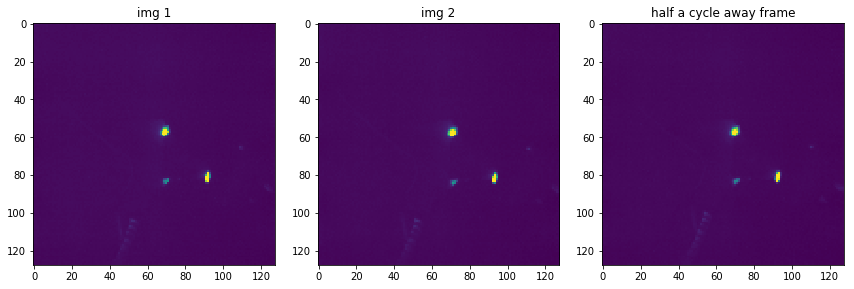

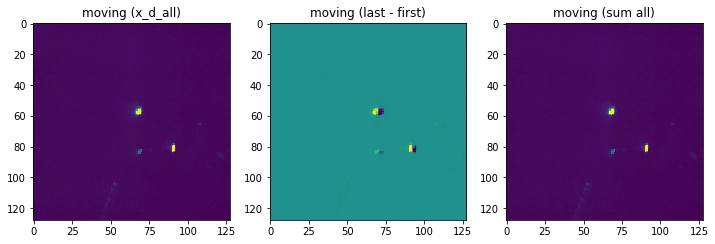

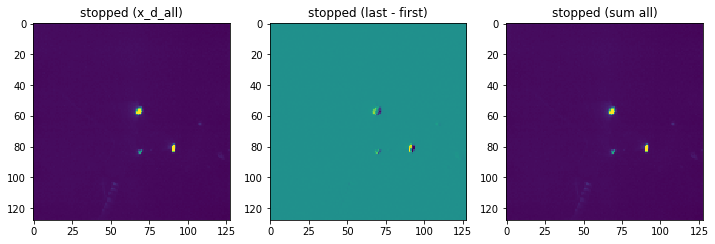

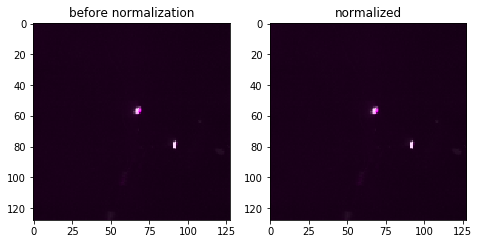

In [3]:
# data exploration

# read some sample images for a quick test
img1 = Image.open(str(images[0]))
img2 = Image.open(str(images[63]))

print('The sample image size is')
print(img1.size)
print(' and it contains this type of data')
print(np.asarray(img1))
print('when normalized it gets like this')
print(np.asarray(img1)/float(255))


#plot 2 of them
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(img1)
plt.title('img 1')
plt.subplot(132)
plt.imshow(img2)
plt.title('img 2')


# see how the summation looks like
plt.subplot(133)
img_last = Image.open(str(images[86]))
plt.imshow(img_last)
plt.title('half a cycle away frame')
fig.tight_layout()


# preparing some quick training data
x_raw = []
y_raw = []
moving_no = 0
stopped_no = 0
# calculate: f(n) - sum_(i = n-13)^(i = n-1) f(i), summations and f(n) - f(n-13)
data_offset = np.cumsum(data_set_len)
print(data_offset)
data_offset = np.insert(data_offset, 0, 0)
print(data_offset)
 
t_h = 14
t_h_1 = t_h -1

for k in range(data_set_no):
    for i in range(data_offset[k] + t_h_1 , data_offset[k+1]):
        x_d_all = np.zeros(img1.size) + np.asarray(Image.open(str(images[i])))/float(255)
        x_sum_all = x_d_all 
        x_last2first = x_d_all - np.asarray(Image.open(str(images[i-t_h_1])) )/float(255)
        for j in range(1,t_h):
            img_tmp = Image.open(str(images[i-j]))
            x_d_all -= np.asarray(img_tmp)/float(255)
            x_sum_all += np.asarray(img_tmp)/float(255)
        img_combined = cv.merge((x_d_all, x_last2first, x_sum_all))
        #x_raw.append(img_combined)
        # put the corresponding label: 1 when stopped breathing and 0 when breathing
        if samples[i] == ['1']:
            y_label = [0.0, 1.0]
            x_raw.append(img_combined)
            y_raw.append(y_label)
            stopped_no += 1    
            #print('a stopped breathing sample')
        else:
            y_label = [1.0, 0.0]  
            if (i%3) == 0:
                x_raw.append(img_combined)
                y_raw.append(y_label)
                moving_no += 1
# some info about the new processed data for training
#print(y_raw)
print('size of train data after calculations ',len(x_raw))
#print(' which is the total of ', sample_size, ' minus ', data_set_no,'x', '= ', data_set_no*13 )
print(' and totally ', moving_no, ' breathing samples vs', stopped_no, ' stopped breathing samples')
print('---------')
stopped_index = 0
print(len(y_raw))
y_tmp = np.array(y_raw)
for i in range(0,len(y_tmp)):
    #print(i)
    #print(y_tmp[i])
    if y_tmp[i][1] == '1.0':
        stopped_index = i
        break
print(stopped_index)
print('---------')
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(x_raw[stopped_index+t_h][:,:,0])
plt.title('moving (x_d_all)')
plt.subplot(132)
plt.imshow(x_raw[stopped_index+t_h][:,:,1])
plt.title('moving (last - first)')
plt.subplot(133)
plt.imshow(x_raw[stopped_index+t_h][:,:,2])
plt.title('moving (sum all)')

fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(x_raw[stopped_index][:,:,0])
plt.title('stopped (x_d_all)')
plt.subplot(132)
plt.imshow(x_raw[stopped_index][:,:,1])
plt.title('stopped (last - first)')
plt.subplot(133)
plt.imshow(x_raw[stopped_index][:,:,2])
plt.title('stopped (sum all)')


x_train, x_val, y_train, y_val = train_test_split(x_raw, y_raw, test_size=0.2, random_state=1, shuffle= True)

print('train data size and type:')
print(len(x_train))
print(type(x_train[0]))
print(x_train[0])
print(y_train[0])

#normalized the inputs between 0-1
x_train_normalized = []
x_val_normalized = []

scale = float(1)/1
print(scale)
for i in range(0,len(x_train)):
    x_train_normalized.append(x_train[i]*scale)
for i in range(0,len(x_val)):
    x_val_normalized.append(x_val[i]*scale)

# test the normalized data
print('an example of the normalized inputs')
print(x_train_normalized[0])
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(x_train[0])
plt.title('before normalization')
plt.subplot(132)
plt.imshow(x_train_normalized[0])
plt.title('normalized')


x_train_normalized = np.array(x_train_normalized)
print('shape of normalized train inputs')
print(x_train_normalized.shape)
x_train_normalized = x_train_normalized.reshape(x_train_normalized.shape[0], 128, 128, 3)
print('reshaped normalized train input dimensions')
print(x_train_normalized.shape)
y_train = np.array(y_train)

x_val_normalized = np.array(x_val_normalized)
print('shape of normalized validation inputs')
print(x_val_normalized.shape)
x_val_normalized = x_val_normalized.reshape(x_val_normalized.shape[0], 128, 128, 3)
print('reshaped normalized validation input dimensions')
print(x_val_normalized.shape)
y_val = np.array(y_val)
#print(y_val)

In [4]:
# importing other useful packages for training
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
# are the following still working in tf 2.1?
from keras.layers import Cropping2D, Lambda


# From the filtered and resized image (160x80x2), crop some less useful pixels from top an bottom for faster processing
crop_top = 0
crop_bottom = 0
# the format of final image that goes to the first convolution layer 
ch, row, col = 3, 128-crop_top-crop_bottom, 128  # Trimmed image format

# Neural network architecture
model = Sequential()
# convolution layers that gradually become deeper
model.add(Conv2D(24, kernel_size = (5, 5), strides =(2,2), padding='same', activation='relu', input_shape=(row, col, ch)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(36, kernel_size = (5, 5), strides =(2,2), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(48, kernel_size = (5, 5), strides =(2,2), padding='same', activation='relu'))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size = (3, 3), strides =(2,2), padding='same', activation='relu'))
model.add(Dropout(0.25))
#removed temp:model.add(Conv2D(64, kernel_size = (3, 3), strides =(2,2), padding='same', activation='relu'))
#removed temp:model.add(Dropout(0.25))
# flattening the outputs and using dense layers up to the final output (i.e. steering angle)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
# outputting the moving/stopped
model.add(Dense(2, activation='softmax'))
print('model defined')
model.summary()

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer='adam',  # Optimizer
              # Loss function to minimize
              #loss='binary_crossentropy',
              loss='categorical_crossentropy',
              # List of metrics to monitor
              metrics=["accuracy"])
print('compiled the model')

model defined
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 24)        1824      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 24)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 36)        21636     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 36)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 36)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4

Using TensorFlow backend.


In [5]:
print('training started')
history = model.fit(x_train_normalized, y_train,
		                batch_size=512,
		                epochs=100,
                        shuffle=True,
		                # We pass some validation for
		                # monitoring validation loss and metrics
		                # at the end of each epoch
		                validation_data=(x_val_normalized, y_val))


training started
Train on 1408 samples, validate on 353 samples
Epoch 1/100
1408/1408 [==============================] - 3s 2ms/step - loss: 0.6911 - accuracy: 0.5021 - val_loss: 0.6785 - val_accuracy: 0.4929
Epoch 2/100
1408/1408 [==============================] - 2s 2ms/step - loss: 0.6759 - accuracy: 0.5050 - val_loss: 0.6418 - val_accuracy: 0.6317
Epoch 3/100
1408/1408 [==============================] - 2s 2ms/step - loss: 0.6401 - accuracy: 0.5952 - val_loss: 0.5958 - val_accuracy: 0.8187
Epoch 4/100
1408/1408 [==============================] - 2s 1ms/step - loss: 0.6034 - accuracy: 0.7578 - val_loss: 0.5791 - val_accuracy: 0.8300
Epoch 5/100
1408/1408 [==============================] - 2s 2ms/step - loss: 0.5913 - accuracy: 0.7919 - val_loss: 0.5770 - val_accuracy: 0.8215
Epoch 6/100
1408/1408 [==============================] - 2s 1ms/step - loss: 0.5858 - accuracy: 0.7969 - val_loss: 0.5717 - val_accuracy: 0.8244
Epoch 7/100
1408/1408 [==============================] - 2s 2ms/st

Epoch 57/100
1408/1408 [==============================] - 2s 2ms/step - loss: 0.3497 - accuracy: 0.8509 - val_loss: 0.3832 - val_accuracy: 0.8357
Epoch 58/100
1408/1408 [==============================] - 2s 2ms/step - loss: 0.3491 - accuracy: 0.8551 - val_loss: 0.3810 - val_accuracy: 0.8357
Epoch 59/100
1408/1408 [==============================] - 2s 2ms/step - loss: 0.3431 - accuracy: 0.8544 - val_loss: 0.3900 - val_accuracy: 0.8300
Epoch 60/100
1408/1408 [==============================] - 2s 2ms/step - loss: 0.3420 - accuracy: 0.8544 - val_loss: 0.3789 - val_accuracy: 0.8357
Epoch 61/100
1408/1408 [==============================] - 2s 2ms/step - loss: 0.3314 - accuracy: 0.8615 - val_loss: 0.3908 - val_accuracy: 0.8215
Epoch 62/100
1408/1408 [==============================] - 2s 2ms/step - loss: 0.3346 - accuracy: 0.8658 - val_loss: 0.3857 - val_accuracy: 0.8414
Epoch 63/100
1408/1408 [==============================] - 2s 2ms/step - loss: 0.3356 - accuracy: 0.8565 - val_loss: 0.3880 -

In [ ]:
model.save('../saved_models/my_model') 

In [ ]:
test_ind = 37
yy = model.predict(x_train_normalized[test_ind].reshape(1, 128, 128, 3), batch_size=1)
print(yy)
print(y_train[test_ind])

In [ ]:
# some psuedo image inputs for quick test
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

# Generate dummy data
x_train = np.random.random((100, 100, 100, 1))
y_train = keras.utils.to_categorical(np.random.randint(10, size=(100, 1)), num_classes=10)
x_test = np.random.random((20, 100, 100, 1))
y_test = keras.utils.to_categorical(np.random.randint(10, size=(20, 1)), num_classes=10)

print(x_train.shape)
print(type(x_train))
print(x_train[0].shape)

model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
#model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)))
model.add(Conv2D(32, kernel_size = (3, 3), strides =(2,2), padding='same', activation='relu', input_shape=(100, 100, 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd)

model.fit(x_train, y_train, batch_size=32, epochs=1)
score = model.evaluate(x_test, y_test, batch_size=32)


In [ ]:
bce = tf.keras.losses.BinaryCrossentropy()
loss = bce([0., 0., 1., 1.], [0., 0., 1., 0.])
print('Loss: ', loss.numpy()) 

test_a = np.zeros((3, 2, 2))
print(test_a)
print(test_a.shape)

img_combined = cv.merge((test_a[0], test_a[1], test_a[2]))

print(img_combined.shape)
for j in range(1,14):
    print(j)
print(y_train)